<a href="https://colab.research.google.com/github/kkipngenokoech/MI/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the data

In [1]:
!wget https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip -O smrdata.zip


--2025-11-16 22:11:36--  https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540873695 (1.4G) [application/zip]
Saving to: ‘smrdata.zip’

smrdata.zip         100%[===================>]   1.43G  17.6MB/s    in 88s     

2025-11-16 22:13:05 (16.6 MB/s) - ‘smrdata.zip’ saved [1540873695/1540873695]



In [2]:
!unzip smrdata.zip > /dev/null 2>&1
%cd smrdata


/content/smrdata


## IMPORTS

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

File: Session1/Session1_LRS001R01.mat
Channels (active only): 13 Samples: 185880 fs: 1000


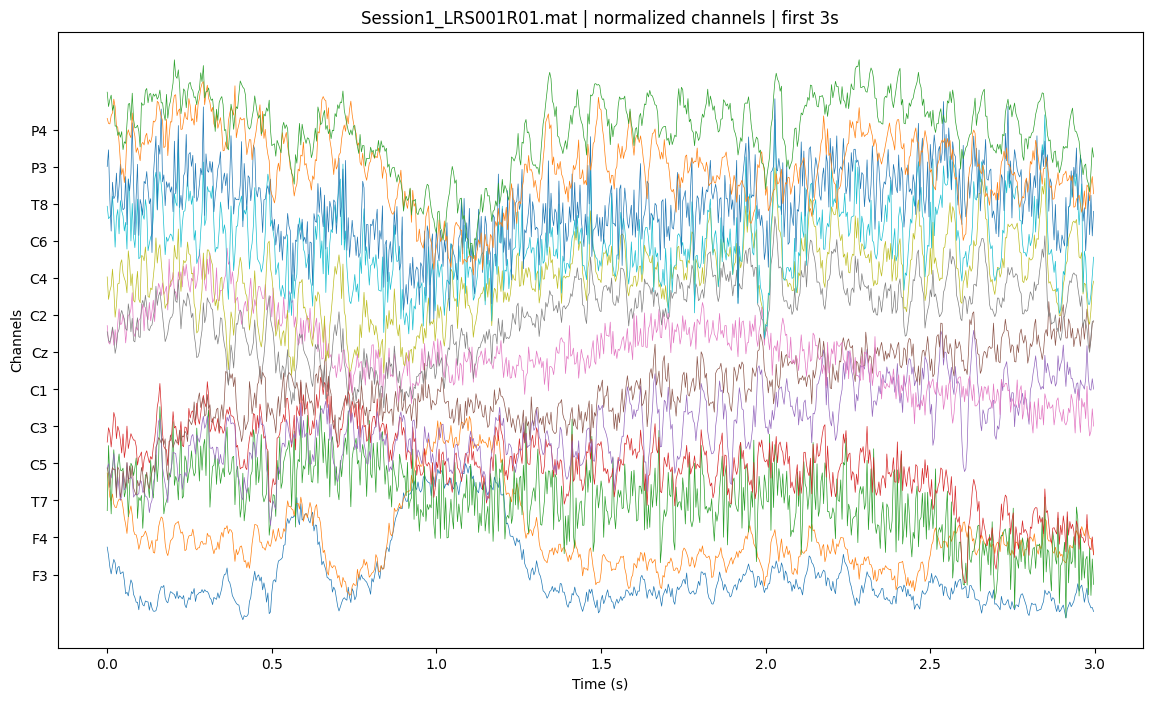

In [4]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- CONFIG ----
data_dir = "Session1"        # folder containing the .mat file
vis_seconds = 3              # how many seconds of data to plot
downsample = 4               # plot every Nth sample
offset = 400                 # vertical shift between channels (μV)
# -----------------

# pick the first .mat file automatically
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".mat")])
if not files:
    raise RuntimeError("No .mat files found.")
matfile = os.path.join(data_dir, files[0])

# load
run = sio.loadmat(matfile)["runData"][0, 0]

fs = int(run["fs"][0, 0])             # sampling rate
X = run["allData"]                   # (channels, samples)

# fix labels
labels_array = run["label"]
labels = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels_array.flatten()]

nch, nsamp = X.shape
assert len(labels) == nch, f"Number of labels ({len(labels)}) does not match number of channels ({nch})"

ts = run["trialStart"].flatten().astype(int)

# ---- determine range first ----
N = min(int(vis_seconds * fs), nsamp)
t = np.arange(N)[::downsample] / fs

# ---- select only active electrodes ----
active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]
active_idx = [i for i, l in enumerate(labels) if l in active_labels]

# subset data
Y = X[active_idx, :N][:, ::downsample]
labels = [labels[i] for i in active_idx]
nch = len(active_idx)

print("File:", matfile)
print("Channels (active only):", nch, "Samples:", nsamp, "fs:", fs)

# ---- plot normalized, vertically shifted signals ----
plt.figure(figsize=(14, 8))
for i in range(nch):
    y = Y[i]
    y_norm = (y - np.mean(y)) / np.std(y)  # z-score
    plt.plot(t, y_norm + i, linewidth=0.5)  # vertical shift by index

plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.yticks(range(nch), labels if nch <= 80 else [])
plt.title(f"{files[0]} | normalized channels | first {vis_seconds}s")
plt.show()


## DATA PRE-PROCESSING

In [5]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 96.0 MB/s eta 0:00:00


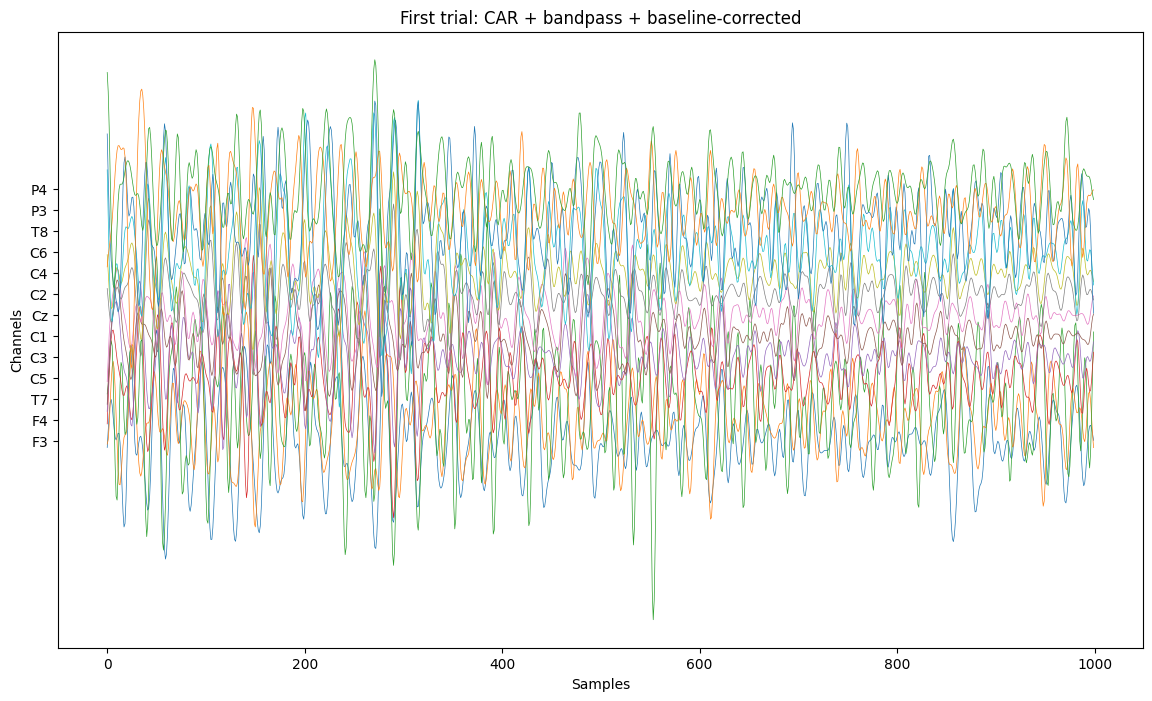

In [13]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os

data_dir = "Session1"
downsample = 4
lowcut = 8
highcut = 30
baseline_window = (-2, 0)
epoch_window = (-2, 2)

files = sorted([f for f in os.listdir(data_dir) if f.endswith(".mat")])
matfile = os.path.join(data_dir, files[0])
run = sio.loadmat(matfile)["runData"][0, 0]

fs = int(run["fs"][0, 0])
X = run["allData"]
labels_array = run["label"]
labels = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels_array.flatten()]

active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]
active_idx = [i for i, l in enumerate(labels) if l in active_labels]
X = X[active_idx, :]
labels = [labels[i] for i in active_idx]
nch = len(active_idx)

def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data, axis=1)

X_filt = bandpass(X, lowcut, highcut, fs)
X_ds = X_filt[:, ::downsample]
fs_new = fs / downsample
X_car = X_ds - X_ds.mean(axis=0, keepdims=True)

ts = run["trialStart"].flatten().astype(int)
targets = run["target"].flatten()
outcome = run["outcome"].flatten()

epoch_samples = int((epoch_window[1] - epoch_window[0]) * fs_new)

epochs = []
y_labels = []

for i, s in enumerate(ts):
    if outcome[i] == 0:
        continue

    start = int((s/fs + epoch_window[0]) * fs_new)
    end   = start + epoch_samples

    if start < 0:
        continue
    if end > X_car.shape[1]:
        continue

    epochs.append(X_car[:, start:end])
    y_labels.append(targets[i])

epochs = np.array(epochs)
y_labels = np.array(y_labels)
y_dl = y_labels - 1

baseline_idx = (
    int((baseline_window[0] - epoch_window[0]) * fs_new),
    int((baseline_window[1] - epoch_window[0]) * fs_new)
)

epochs_baseline = epochs - epochs[:, :, baseline_idx[0]:baseline_idx[1]].mean(axis=2, keepdims=True)

plt.figure(figsize=(14,8))
scale = 2.0
for i in range(nch):
    y = epochs_baseline[0, i, :]
    plt.plot(y + i*scale, linewidth=0.5)
plt.yticks([i*scale for i in range(nch)], labels)
plt.xlabel("Samples")
plt.ylabel("Channels")
plt.title("First trial: CAR + bandpass + baseline-corrected")
plt.show()


## FEATURE EXTRACTION

### Bandpower + LDA

In [8]:
# from scipy.signal import welch
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# def bandpower_epochs(epochs, fs, bands=[(8,12),(13,30)]):
#     n_trials, n_channels, n_samples = epochs.shape
#     features = []
#     for tr in range(n_trials):
#         trial_features = []
#         for ch in range(n_channels):
#             f, Pxx = welch(epochs[tr,ch,:], fs=fs, nperseg=256)
#             for (low, high) in bands:
#                 idx = np.logical_and(f >= low, f <= high)
#                 trial_features.append(Pxx[idx].mean())
#         features.append(trial_features)
#     return np.array(features)

# X_features = bandpower_epochs(epochs_baseline, fs_new)
# y_labels = np.array(run['outcome'].flatten())  # assuming 0/1 for Left/Right MI
# clf = LDA()
# clf.fit(X_features, y_labels)


### Bandpower + SVM

In [9]:
# from sklearn.svm import SVC
# clf_svm = SVC(kernel='linear')
# clf_svm.fit(X_features, y_labels)


### Common Spatial Patterns (CSP) + LDA

In [10]:
# from mne.decoding import CSP

# csp = CSP(n_components=4, reg=None)
# X_csp = csp.fit_transform(epochs_baseline, y_labels)
# clf_csp = LDA()
# clf_csp.fit(X_csp, y_labels)


### deep learning

In [11]:
# # Using Keras / TensorFlow
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout

# model = Sequential([
#     Conv1D(16, kernel_size=64, padding='same', input_shape=(nch, epoch_samples)),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv1D(32, kernel_size=32, padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     GlobalAveragePooling1D(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(epochs_baseline, y_labels, epochs=50, batch_size=16, validation_split=0.2)


### general pipeline

In [15]:
import numpy as np
from scipy.signal import welch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras import Input

# -------------------------
# ASSUMPTIONS (from preprocessing)
# -------------------------
# epochs_baseline : np.ndarray, shape (n_trials, n_channels, n_samples)
# y_labels        : np.ndarray, shape (n_trials,) with values {1,2}
# fs_new          : sampling rate after downsampling (scalar)
#
# These come from your preprocessing script. The pipeline below uses those variables.

# quick sanity checks
assert isinstance(epochs_baseline, np.ndarray), "epochs_baseline must be a numpy array"
assert epochs_baseline.ndim == 3, "epochs_baseline must have shape (n_trials, n_channels, n_samples)"
assert epochs_baseline.shape[0] == y_labels.shape[0], "Number of epochs and labels must match"

# convert labels to 0/1 (required by keras and also fine for sklearn)
y = y_labels.astype(int) - 1    # now in {0,1}
n_trials, n_channels, n_samples = epochs_baseline.shape

# -------------------------
# 1) Bandpower features (mu + beta)
# -------------------------
def bandpower_epochs(epochs, fs, bands=[(8,12),(13,30)], nperseg=256):
    feats = []
    for tr in range(epochs.shape[0]):
        feat_tr = []
        for ch in range(epochs.shape[1]):
            f, Pxx = welch(epochs[tr, ch, :], fs=fs, nperseg=min(nperseg, epochs.shape[2]))
            for (low, high) in bands:
                idx = np.logical_and(f >= low, f <= high)
                feat_tr.append(Pxx[idx].mean())
        feats.append(feat_tr)
    return np.array(feats)

X_bp = bandpower_epochs(epochs_baseline, fs=fs_new)

# -------------------------
# 1a) Bandpower + LDA (5-fold stratified CV)
# -------------------------
lda = LDA()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_lda = cross_val_score(lda, X_bp, y, cv=cv)
print("Bandpower + LDA PVC: %.2f%% (± %.2f%%)" % (scores_lda.mean()*100, scores_lda.std()*100))

# -------------------------
# 1b) Bandpower + SVM (linear)
# -------------------------
svm = SVC(kernel='linear')
scores_svm = cross_val_score(svm, X_bp, y, cv=cv)
print("Bandpower + SVM PVC: %.2f%% (± %.2f%%)" % (scores_svm.mean()*100, scores_svm.std()*100))

# -------------------------
# 2) CSP + LDA
# -------------------------
# CSP expects epochs shape (n_trials, n_channels, n_times)
csp = CSP(n_components=4, reg=None, log=True)  # log=True -> returns log-variance features
X_csp = csp.fit_transform(epochs_baseline, y)
lda_csp = LDA()
scores_csp = cross_val_score(lda_csp, X_csp, y, cv=cv)
print("CSP + LDA PVC: %.2f%% (± %.2f%%)" % (scores_csp.mean()*100, scores_csp.std()*100))

# -------------------------
# Prepare data for deep learning
# -------------------------
# Keras wants shape (n_trials, n_samples, n_channels) for Conv1D along time
X_dl = epochs_baseline.transpose(0, 2, 1).astype('float32')  # (n_trials, n_samples, n_channels)
y_dl = y.astype('int32')

# -------------------------
# 3) 1D CNN (simple)
# -------------------------
cnn = Sequential([
    Input(shape=(n_samples, n_channels)),
    Conv1D(16, kernel_size=64, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(32, kernel_size=32, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_dl, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
cnn_eval = cnn.evaluate(X_dl, y_dl, verbose=0)
print("1D CNN PVC (train accuracy): %.2f%%" % (cnn_eval[1]*100))

# -------------------------
# 4) EEGNet-like (lightweight CNN)
# -------------------------
def EEGNet_like(input_shape, n_classes=2):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(8, kernel_size=64, padding='same'),
        BatchNormalization(),
        Activation('elu'),
        Conv1D(16, kernel_size=16, padding='same'),
        BatchNormalization(),
        Activation('elu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    return model

eegnet = EEGNet_like((n_samples, n_channels), n_classes=2)
eegnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
eegnet.fit(X_dl, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
eegnet_eval = eegnet.evaluate(X_dl, y_dl, verbose=0)
print("EEGNet-like PVC (train accuracy): %.2f%%" % (eegnet_eval[1]*100))

# -------------------------
# Notes / recommendations
# -------------------------
# - Classical methods report cross-validated PVC (recommended for fair comparison).
# - Deep learning models above report training/validation behavior (use a held-out test set for final PVC).
# - You should persist model predictions on a held-out test set (or use nested CV) to compute final PVC to compare against online outcome.
# - Consider saving trained models, confusion matrices, and per-class PVC for analysis.


Bandpower + LDA PVC: 58.33% (± 25.82%)
Bandpower + SVM PVC: 80.00% (± 29.15%)
Computing rank from data with rank=None
    Using tolerance 3.3 (2.2e-16 eps * 13 dim * 1.2e+15  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 13 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 13 -> 12
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
CSP + LDA PVC: 73.33% (± 22.61%)
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4615 - loss: 0.7488 - val_accuracy: 0.7500 - val_loss: 0.5858
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.4615 - loss: 0.8497 - val_accuracy: 0.7500 - val_loss: 0.5781
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step - accuracy: 0.7692 - loss: 0.7318 - val_accuracy: 0.7500 - val_loss: 0.6465
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - accuracy: 0.5385 - loss: 0.7063 - val_accuracy: 0.75

In [16]:
!ls

Session1  Session2


In [17]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt

# -------- CONFIG --------
session_dirs = ["Session1", "Session2"]
downsample = 4
lowcut = 8
highcut = 30
baseline_window = (-2,0)
epoch_window = (-2,2)

active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]

def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data, axis=1)

X_all = []
y_all = []
target_len = None

for session in session_dirs:
    files = sorted([f for f in os.listdir(session) if f.endswith(".mat")])

    for f in files:
        run = sio.loadmat(os.path.join(session,f))["runData"][0,0]

        fs = int(run["fs"][0,0])
        X = run["allData"]
        labels_array = run["label"]
        labels = [str(l[0]) if isinstance(l,np.ndarray) else str(l) for l in labels_array.flatten()]

        idx = [i for i,l in enumerate(labels) if l in active_labels]
        X = X[idx,:]

        X = bandpass(X, lowcut, highcut, fs)
        X = X[:, ::downsample]
        fs_new = fs/downsample
        X = X - X.mean(axis=0, keepdims=True)

        outcome = run["outcome"].flatten()
        valid = np.where(outcome != 0)[0]
        ts = run["trialStart"].flatten().astype(int)
        targets = run["target"].flatten()

        epoch_samples = int((epoch_window[1]-epoch_window[0]) * fs_new)
        epochs = []
        y = []

        for i,s in enumerate(ts):
            if i not in valid:
                continue
            start = int((s/fs + epoch_window[0])*fs_new)
            end   = start + epoch_samples
            if start<0 or end> X.shape[1]:
                continue
            ep = X[:, start:end]
            epochs.append(ep)
            y.append(targets[i])

        if len(epochs)==0:
            continue

        epochs = np.stack(epochs,axis=0)
        y = np.array(y)

        b0 = int((baseline_window[0]-epoch_window[0])*fs_new)
        b1 = int((baseline_window[1]-epoch_window[0])*fs_new)
        epochs = epochs - epochs[:,:,b0:b1].mean(axis=2,keepdims=True)

        if target_len is None:
            target_len = epochs.shape[2]
        else:
            if epochs.shape[2] != target_len:
                m = min(epochs.shape[2], target_len)
                epochs = epochs[:,:,:m]

        X_all.append(epochs)
        y_all.append(y)

X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
y_dl = y_all - 1
X_cnn = X_all.transpose(0,2,1)


In [18]:
import numpy as np
from scipy.signal import welch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras import Input

# -------------------------
# ASSUMPTIONS (from preprocessing)
# -------------------------
# epochs_baseline : np.ndarray, shape (n_trials, n_channels, n_samples)
# y_labels        : np.ndarray, shape (n_trials,) with values {1,2}
# fs_new          : sampling rate after downsampling (scalar)
#
# These come from your preprocessing script. The pipeline below uses those variables.

# quick sanity checks
assert isinstance(epochs_baseline, np.ndarray), "epochs_baseline must be a numpy array"
assert epochs_baseline.ndim == 3, "epochs_baseline must have shape (n_trials, n_channels, n_samples)"
assert epochs_baseline.shape[0] == y_labels.shape[0], "Number of epochs and labels must match"

# convert labels to 0/1 (required by keras and also fine for sklearn)
y = y_labels.astype(int) - 1    # now in {0,1}
n_trials, n_channels, n_samples = epochs_baseline.shape

# -------------------------
# 1) Bandpower features (mu + beta)
# -------------------------
def bandpower_epochs(epochs, fs, bands=[(8,12),(13,30)], nperseg=256):
    feats = []
    for tr in range(epochs.shape[0]):
        feat_tr = []
        for ch in range(epochs.shape[1]):
            f, Pxx = welch(epochs[tr, ch, :], fs=fs, nperseg=min(nperseg, epochs.shape[2]))
            for (low, high) in bands:
                idx = np.logical_and(f >= low, f <= high)
                feat_tr.append(Pxx[idx].mean())
        feats.append(feat_tr)
    return np.array(feats)

X_bp = bandpower_epochs(epochs_baseline, fs=fs_new)

# -------------------------
# 1a) Bandpower + LDA (5-fold stratified CV)
# -------------------------
lda = LDA()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_lda = cross_val_score(lda, X_bp, y, cv=cv)
print("Bandpower + LDA PVC: %.2f%% (± %.2f%%)" % (scores_lda.mean()*100, scores_lda.std()*100))

# -------------------------
# 1b) Bandpower + SVM (linear)
# -------------------------
svm = SVC(kernel='linear')
scores_svm = cross_val_score(svm, X_bp, y, cv=cv)
print("Bandpower + SVM PVC: %.2f%% (± %.2f%%)" % (scores_svm.mean()*100, scores_svm.std()*100))

# -------------------------
# 2) CSP + LDA
# -------------------------
# CSP expects epochs shape (n_trials, n_channels, n_times)
csp = CSP(n_components=4, reg=None, log=True)  # log=True -> returns log-variance features
X_csp = csp.fit_transform(epochs_baseline, y)
lda_csp = LDA()
scores_csp = cross_val_score(lda_csp, X_csp, y, cv=cv)
print("CSP + LDA PVC: %.2f%% (± %.2f%%)" % (scores_csp.mean()*100, scores_csp.std()*100))

# -------------------------
# Prepare data for deep learning
# -------------------------
# Keras wants shape (n_trials, n_samples, n_channels) for Conv1D along time
X_dl = epochs_baseline.transpose(0, 2, 1).astype('float32')  # (n_trials, n_samples, n_channels)
y_dl = y.astype('int32')

# -------------------------
# 3) 1D CNN (simple)
# -------------------------
cnn = Sequential([
    Input(shape=(n_samples, n_channels)),
    Conv1D(16, kernel_size=64, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(32, kernel_size=32, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_dl, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
cnn_eval = cnn.evaluate(X_dl, y_dl, verbose=0)
print("1D CNN PVC (train accuracy): %.2f%%" % (cnn_eval[1]*100))

# -------------------------
# 4) EEGNet-like (lightweight CNN)
# -------------------------
def EEGNet_like(input_shape, n_classes=2):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(8, kernel_size=64, padding='same'),
        BatchNormalization(),
        Activation('elu'),
        Conv1D(16, kernel_size=16, padding='same'),
        BatchNormalization(),
        Activation('elu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    return model

eegnet = EEGNet_like((n_samples, n_channels), n_classes=2)
eegnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
eegnet.fit(X_dl, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
eegnet_eval = eegnet.evaluate(X_dl, y_dl, verbose=0)
print("EEGNet-like PVC (train accuracy): %.2f%%" % (eegnet_eval[1]*100))

# -------------------------
# Notes / recommendations
# -------------------------
# - Classical methods report cross-validated PVC (recommended for fair comparison).
# - Deep learning models above report training/validation behavior (use a held-out test set for final PVC).
# - You should persist model predictions on a held-out test set (or use nested CV) to compute final PVC to compare against online outcome.
# - Consider saving trained models, confusion matrices, and per-class PVC for analysis.


Bandpower + LDA PVC: 58.33% (± 25.82%)
Bandpower + SVM PVC: 80.00% (± 29.15%)
Computing rank from data with rank=None
    Using tolerance 3.3 (2.2e-16 eps * 13 dim * 1.2e+15  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 13 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 13 -> 12
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
CSP + LDA PVC: 73.33% (± 22.61%)
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5385 - loss: 0.7963 - val_accuracy: 0.7500 - val_loss: 0.6433
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.7692 - loss: 0.4723 - val_accuracy: 0.7500 - val_loss: 0.9812
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.6923 - loss: 0.6866 - val_accuracy: 0.7500 - val_loss: 1.3416
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.4615 - loss: 0.8309 - val_accuracy: 0.7500

In [20]:
import scipy.io as sio
import os
import numpy as np

def load_all_runs(session_dirs):
    runs = []
    for session in session_dirs:
        mat_files = sorted([
            os.path.join(session, f)
            for f in os.listdir(session)
            if f.endswith(".mat")
        ])
        for mf in mat_files:
            r = sio.loadmat(mf)["runData"][0,0]
            runs.append({
                "run_name": f"{session}/{os.path.basename(mf)}",
                "outcome": r["outcome"].flatten(),
                "target": r["target"].flatten(),
                "trialStart": r["trialStart"].flatten(),
                "allData": r["allData"],
                "fs": int(r["fs"][0,0])
            })
    return runs

session_dirs = ["Session1", "Session2"]   # UPDATE IF NAMES DIFFER
runs = load_all_runs(session_dirs)





import numpy as np

def pvc_from_outcome_array(outcome_array):
    """
    outcome_array: 1D array-like of outcomes from a run (values: 1 hit, -1 miss, 0 aborted)
    Returns: (pvc_percent, n_hits, n_misses, n_aborted)
    """
    outcome = np.asarray(outcome_array).flatten()
    n_hits = np.sum(outcome == 1)
    n_misses = np.sum(outcome == -1)
    n_aborted = np.sum(outcome == 0)
    n_valid = int(n_hits + n_misses)
    if n_valid == 0:
        return float('nan'), int(n_hits), int(n_misses), int(n_aborted)
    pvc = n_hits / n_valid * 100.0
    return pvc, int(n_hits), int(n_misses), int(n_aborted)

# Example: single run (if you have the run matrix loaded as `run`)
# run_outcome = run["outcome"].flatten()
# pvc, hits, misses, aborted = pvc_from_outcome_array(run_outcome)
# print(f"Run PVC={pvc:.1f}%  hits={hits} misses={misses} aborted={aborted}")

# If you built a list `runs` from load_all_runs() where each run is a dict with key 'outcome':
def compute_pvcs_for_runs(runs):
    """
    runs: list of dicts produced by the loader. Each dict must contain 'outcome' and 'run_name'.
    Returns list of dictionaries with pvc info per run.
    """
    out = []
    for r in runs:
        pvc, hits, misses, aborted = pvc_from_outcome_array(r['outcome'])
        out.append({
            'run_name': r.get('run_name', 'unknown'),
            'pvc': pvc,
            'hits': hits,
            'misses': misses,
            'aborted': aborted,
            'valid_trials': hits + misses
        })
    return out

# Aggregated summary across runs (weighted by number of valid trials)
def aggregate_pvc(run_infos):
    """
    run_infos: list of dicts produced by compute_pvcs_for_runs()
    Returns overall PVC across all runs (weighted by valid trial counts) and totals.
    """
    total_hits = sum(r['hits'] for r in run_infos)
    total_misses = sum(r['misses'] for r in run_infos)
    total_aborted = sum(r['aborted'] for r in run_infos)
    total_valid = total_hits + total_misses
    if total_valid == 0:
        return float('nan'), total_hits, total_misses, total_aborted
    overall_pvc = total_hits / total_valid * 100.0
    return overall_pvc, total_hits, total_misses, total_aborted

# -------------------------
# Usage example (after load_all_runs()):
# -------------------------
# runs = load_all_runs(session_dirs)   # as in previous code
run_infos = compute_pvcs_for_runs(runs)
for info in run_infos:
    print(f"{info['run_name']}: PVC={info['pvc']:.1f}%, hits={info['hits']}, misses={info['misses']}, aborted={info['aborted']}")

overall_pvc, hits, misses, aborted = aggregate_pvc(run_infos)
print(f"Overall PVC across all runs: {overall_pvc:.2f}% (hits={hits}, misses={misses}, aborted={aborted})")


Session1/Session1_LRS001R01.mat: PVC=58.8%, hits=10, misses=7, aborted=8
Session1/Session1_LRS001R02.mat: PVC=50.0%, hits=8, misses=8, aborted=9
Session1/Session1_LRS001R03.mat: PVC=60.0%, hits=6, misses=4, aborted=15
Session1/Session1_LRS001R04.mat: PVC=64.3%, hits=9, misses=5, aborted=11
Session1/Session1_LRS001R05.mat: PVC=50.0%, hits=9, misses=9, aborted=7
Session1/Session1_LRS001R06.mat: PVC=35.3%, hits=6, misses=11, aborted=8
Session1/Session1_LRS001R07.mat: PVC=66.7%, hits=10, misses=5, aborted=10
Session1/Session1_UDS001R01.mat: PVC=57.1%, hits=12, misses=9, aborted=4
Session1/Session1_UDS001R02.mat: PVC=41.7%, hits=10, misses=14, aborted=1
Session1/Session1_UDS001R03.mat: PVC=57.1%, hits=12, misses=9, aborted=4
Session1/Session1_UDS001R04.mat: PVC=55.0%, hits=11, misses=9, aborted=5
Session1/Session1_UDS001R05.mat: PVC=38.9%, hits=7, misses=11, aborted=7
Session1/Session1_UDS001R06.mat: PVC=47.4%, hits=9, misses=10, aborted=6
Session1/Session1_UDS001R07.mat: PVC=47.6%, hits=10

In [44]:
results = {}
results["Online PVC"]        = overall_pvc/100
results["Bandpower+LDA"] = scores_lda.mean()
results["CSP+LDA"]       = scores_csp.mean()
results["Bandpower+SVM"] = scores_svm.mean()
results["EEGNet"]        = eegnet_eval[1]
results["CNN"]           = cnn_eval[1]


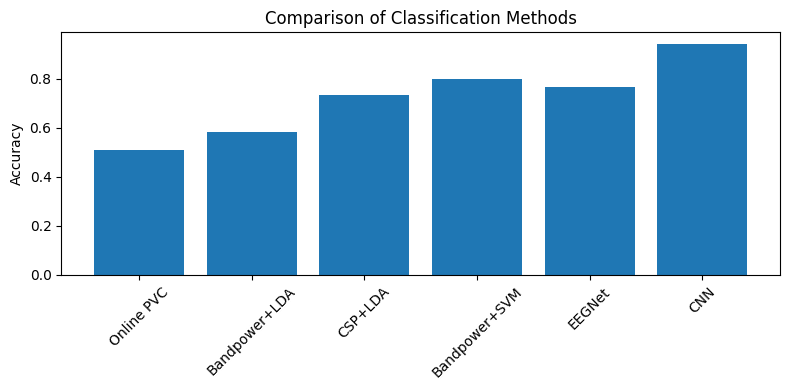

In [45]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[m] for m in methods]

plt.figure(figsize=(8,4))
plt.bar(methods, accuracies)
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Methods")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
overall_pvc/100

0.5093167701863354

In [34]:
scores_csp.mean()

np.float64(0.7333333333333333)